In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
data_store = []

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt 
import optax

from markovsbi.tasks import get_task
from markovsbi.utils.sde_utils import init_sde
from markovsbi.models.simple_scoremlp import build_score_mlp, precondition_functions
from markovsbi.models.train_utils import build_batch_sampler,build_loss_fn

In [3]:
jax.devices()

[cuda(id=0)]

In [4]:

data_store_local = []
dim = 10
key_number = 2






key = jax.random.PRNGKey(key_number)

In [62]:
task = get_task("simple1dnonstationary")
prior = task.get_prior()
simulator = task.get_simulator()

In [63]:
simulator(key, jnp.ones(1), T=2, ts=jnp.arange(0, 1)).shape

(1, 1)

In [64]:
data = task.get_data(key, 10_000, 2, max_T=1000)

In [65]:
sde, weight_fn = init_sde(data, name="VPSDE")

In [66]:
key, key_init = jax.random.split(key)

In [67]:
c_in, c_noise, c_out = precondition_functions(sde)
init_fn, score_net = build_score_mlp(2, c_in=c_in, c_noise=c_noise, c_out=c_out)
batch_sampler = build_batch_sampler(data, nonstationary=True)
loss_fn = build_loss_fn("dsm", score_net, sde,weight_fn)

In [68]:
theta_batch, x_batch, t_batch = batch_sampler(key_init, 10)
d = theta_batch.shape[1]
print(theta_batch.shape, x_batch.shape, t_batch.shape)

(10, 1) (10, 2, 1) (10, 2)


In [69]:
params = init_fn(key_init, jnp.ones((10,)), theta_batch, x_batch, t_batch)

In [70]:
loss_fn(params, key,theta_batch, x_batch, time=t_batch)

Array(0.352, dtype=float32)

In [71]:

schedule = optax.cosine_onecycle_schedule (
    100_000, 5e-4,
)
optimizer = optax.chain(optax.adaptive_grad_clip(50), optax.adamw(schedule))
opt_state = optimizer.init(params)

In [72]:
@jax.jit
def update(params, rng, opt_state, theta_batch, x_batch, t_batch):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng, theta_batch, x_batch, time=t_batch)
    updates, opt_state = optimizer.update(grads, opt_state, params=params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

In [73]:
for i in range(10):
    l = 0.
    for _ in range(10000):
        key, key_batch = jax.random.split(key)
        theta_batch, x_batch, t_batch = batch_sampler(key_batch, 1024)
        loss, params, opt_state = update(params, key, opt_state, theta_batch, x_batch,t_batch)
        l += loss/10000
    print(l)

KeyboardInterrupt: 

In [74]:
from markovsbi.sampling.score_fn import FNPEScoreFn, UncorrectedScoreFn, GaussCorrectedScoreFn,CorrectedScoreFn, ScoreFn

In [75]:
score_fn = FNPEScoreFn(score_net, params, sde, prior)
score_fn = UncorrectedScoreFn(score_net, params, sde,prior)
score_fn = GaussCorrectedScoreFn(score_net, params, sde, prior)
#score_fn = CorrectedScoreFn(score_net, params, sde, prior)

In [76]:
#key = jax.random.PRNGKey(0)
theta_o = prior.sample(key)
print(theta_o)
num_obs = 101
t_o = jnp.arange(0, num_obs).astype(jnp.float32)
x_o = simulator(key, theta_o, num_obs, ts=t_o)
print(theta_o.shape, x_o.shape, t_o.shape)

[-1.165]
(1,) (101, 1) (101,)


In [85]:
score_fn.estimate_hyperparameters(x_o, task.input_shape, key, diag=False,t_o=t_o)

(100, 1000, 1)


ValueError: Argument to inv must have shape [..., n, n], got (1, 100).

In [78]:

from markovsbi.sampling.sample import Diffuser
from markovsbi.sampling.kernels import EulerMaruyama, PredictorCorrector, DDIM
 
kernel = EulerMaruyama(score_fn)
time_grid = jnp.linspace(sde.T_min, sde.T_max, 2000)
sampler = Diffuser(kernel, time_grid, (d,))


In [79]:
from markovsbi.models.utils import get_windows

window_size=2
window_stride=1
individual_x_o = get_windows(x_o, window_size, window_stride, axis=0)
t_o_windows = get_windows(t_o, window_size, window_stride, axis=0)


individual_x_o.shape, t_o_windows.shape

((100, 2, 1), (100, 2))

In [80]:
task.input_shape

(1,)

In [81]:
individual_samples.shape

(100, 1000, 10)

In [82]:
print(x_o.shape, t_o.shape)

sampler.simulate(key, x_o, t_o)

(101, 1) (101,)


Array([[0.361],
       [0.302],
       [0.225],
       ...,
       [0.84 ],
       [0.834],
       [0.831]], dtype=float32)

In [83]:
#traces = jax.vmap(lambda k,x,t: sampler.simulate, in_axes=(0,None, None))(jax.random.split(key,(100,)), x_o, t_o)
traces = jax.vmap(sampler.simulate, in_axes=(0,None, None))(jax.random.split(key,(50,)), x_o, t_o)

(-5.0, 5.0)

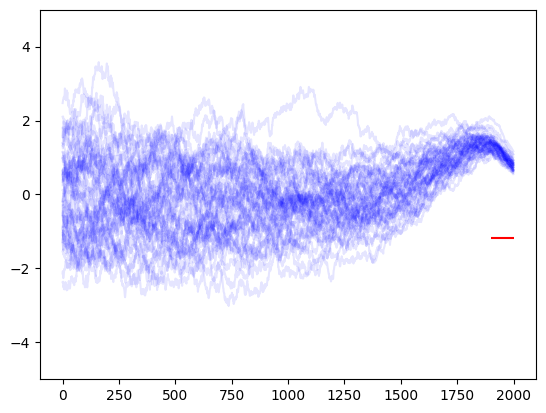

In [84]:
for t in traces:
    plt.plot(t, alpha=0.1, color="blue")
plt.hlines(theta_o, 1900, 2000, color="red")
plt.ylim(-5,5)

In [58]:
from functools import partial
samples = jax.vmap(partial(sampler.sample, x_o=x_o, t_o=t_o))(jax.random.split(key, 1000))

print(samples.shape)

(1000, 10)


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


10
(100, 10)
(100, 10)


/tmp/ipykernel_27224/4241538473.py:13: UserWarning: offdiag is deprecated, use upper or lower instead.
  pairplot([samples, torch.tensor(true_samples)], points = np.array(theta_o), limits = [(-5,5)]*10, offdiag="scatter")


(<Figure size 1000x1000 with 100 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='dim 2'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='dim 3'>, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='dim 4'>, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='dim 5'>,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: xlabel='dim 6'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: xlabel='dim 7'>, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, 

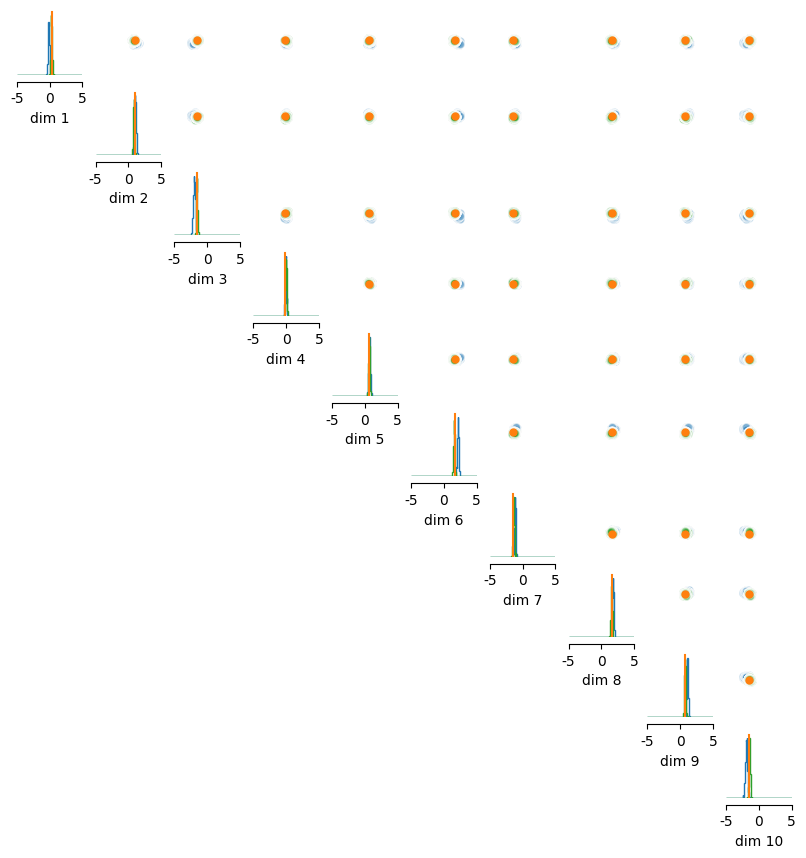

In [59]:
from sbi.analysis import pairplot
from sympy import limit
import numpy as np
import torch


true_posterior = task.get_true_posterior(x_o)
true_samples = true_posterior.sample(key, (1000,))   
#true_samples = torch.tensor(np.array(true_samples)) 

true_samples = np.array(true_samples).reshape(-1, d)

pairplot([samples, torch.tensor(true_samples)], points = np.array(theta_o), limits = [(-5,5)]*10, offdiag="scatter")
#plt.hist(samples[:,0])
#plt.hist(true_samples[:,0])

In [830]:
from sbi.utils.metrics import c2st 

print(torch.tensor(np.array(samples))[:1000].shape)


print(true_samples[:1000].shape)

distance = np.array(c2st(torch.tensor(np.array(samples)), torch.tensor(true_samples)))

print(distance)



print(data_store_local)

torch.Size([1000, 10])
(1000, 10)
1.0
[10, 2, 11, array(1.)]


10
(100, 10)
(100, 10)


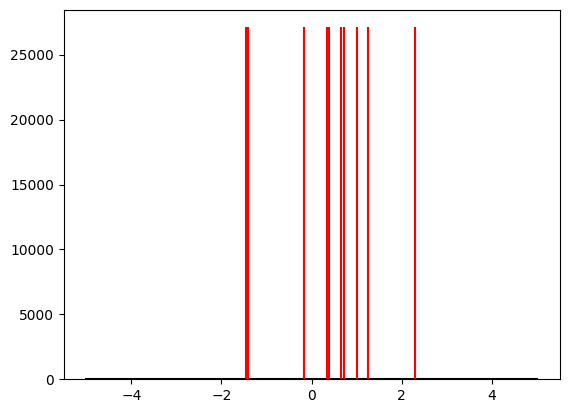

In [831]:
true_posterior = task.get_true_posterior(x_o)
l = jnp.linspace(-5, 5, 500)
logpdf = true_posterior.log_prob(l.reshape(-1,1))

plt.hist(samples.flatten(), bins=200, density=True, range=(-5,5), alpha=0.5)
plt.plot(l, jnp.exp(logpdf), color="black")
plt.vlines(theta_o, 0, jnp.exp(true_posterior.log_prob(theta_o)), color="red")

In [832]:

data_store_local = []


data_store_local.append(dim)
data_store_local.append(key_number)
data_store_local.append(num_obs)
data_store_local.append(distance)

data_store.append(np.array(data_store_local))
print(data_store_local)

print(data_store)



[10, 2, 101, array(1.)]
[array([  1.  ,   0.  , 101.  ,   0.53]), array([ 1.   ,  0.   , 11.   ,  0.571]), array([1.   , 0.   , 2.   , 0.505]), array([  1.   ,   1.   , 101.   ,   0.597]), array([ 1.   ,  1.   , 11.   ,  0.877]), array([1.   , 1.   , 2.   , 0.521]), array([  1.   ,   2.   , 101.   ,   0.632]), array([ 1.   ,  2.   , 11.   ,  0.619]), array([1.   , 2.   , 2.   , 0.551]), array([  1.   ,   3.   , 101.   ,   0.625]), array([ 1.   ,  3.   , 11.   ,  0.992]), array([1.   , 3.   , 2.   , 0.509]), array([  1.   ,   4.   , 101.   ,   0.736]), array([ 1.   ,  4.   , 11.   ,  0.571]), array([1.   , 4.   , 2.   , 0.527]), array([  2.  ,   0.  , 101.  ,   0.53]), array([ 2.   ,  0.   , 11.   ,  0.571]), array([2.   , 0.   , 2.   , 0.505]), array([2.   , 0.   , 2.   , 0.982]), array([2.   , 0.   , 2.   , 0.632]), array([ 2.   ,  0.   , 11.   ,  0.545]), array([  2.   ,   0.   , 101.   ,   0.697]), array([  2.   ,   1.   , 101.   ,   0.647]), array([ 2.   ,  1.   , 11.   ,  0.918]),

In [833]:
import pandas as pd

sample = pd.DataFrame(data_store, columns=['dim', 'key_number', 'obs_length','C2ST'])
print(sample)
sample.to_csv('Nonstationary_{}_10k.csv'.format("Proposal"))

     dim  key_number  obs_length      C2ST
0    1.0         0.0       101.0  0.530500
1    1.0         0.0        11.0  0.570500
2    1.0         0.0         2.0  0.505000
3    1.0         1.0       101.0  0.596500
4    1.0         1.0        11.0  0.876500
5    1.0         1.0         2.0  0.521000
6    1.0         2.0       101.0  0.632000
7    1.0         2.0        11.0  0.619000
8    1.0         2.0         2.0  0.551000
9    1.0         3.0       101.0  0.625500
10   1.0         3.0        11.0  0.992000
11   1.0         3.0         2.0  0.509500
12   1.0         4.0       101.0  0.736000
13   1.0         4.0        11.0  0.571000
14   1.0         4.0         2.0  0.527000
15   2.0         0.0       101.0  0.530500
16   2.0         0.0        11.0  0.570500
17   2.0         0.0         2.0  0.505000
18   2.0         0.0         2.0  0.982333
19   2.0         0.0         2.0  0.631500
20   2.0         0.0        11.0  0.545500
21   2.0         0.0       101.0  0.697500
22   2.0   